**Check GPU**

first we want to check for CUDA on the mechine

In [1]:
import torch, os, platform, time, math
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA:", torch.version.cuda)

!pip -q install transformers torchvision


PyTorch: 2.9.0+cu128
CUDA available: True
GPU: Tesla T4
CUDA: 12.8


**Benchmark functions**

In [2]:
import time
import torch

def reset_cuda():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

@torch.no_grad()
def bench_inference_step(model_or_fn, inputs, autocast_enabled=False, warmup=20, iters=60, device=None):
    """
    model_or_fn: either nn.Module OR a callable that runs a forward pass
    inputs: tensor or tuple/list of tensors
    device: optional torch.device if model_or_fn is not a Module
    """
    # If it's a torch module, set eval + get device
    if isinstance(model_or_fn, torch.nn.Module):
        model_or_fn.eval()
        device = next(model_or_fn.parameters()).device
        forward = model_or_fn
    else:
        # Callable path (no .eval(), no .parameters())
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        forward = model_or_fn

    # Warmup
    for _ in range(warmup):
        with torch.cuda.amp.autocast(enabled=autocast_enabled):
            _ = forward(*inputs) if isinstance(inputs, (tuple, list)) else forward(inputs)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t0 = time.perf_counter()
    for _ in range(iters):
        with torch.cuda.amp.autocast(enabled=autocast_enabled):
            _ = forward(*inputs) if isinstance(inputs, (tuple, list)) else forward(inputs)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t1 = time.perf_counter()

    ms_per_iter = (t1 - t0) * 1000.0 / iters
    peak_mem_mb = None
    if torch.cuda.is_available():
        peak_mem_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return ms_per_iter, peak_mem_mb


In [3]:
import torchvision.models as models
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(weights=None).to(device)
resnet.eval()

def run_resnet(batch_sizes=(1,2,4,8,16,32,64), fp16=False, img_size=224):
    results = []
    for b in batch_sizes:
        reset_cuda()
        x = torch.randn(b, 3, img_size, img_size, device=device)
        ms, mem = bench_inference_step(resnet, x, autocast_enabled=fp16)
        # throughput imgs/sec
        thr = (b / (ms/1000.0))
        results.append((b, ms, thr, mem))
    return results

res_fp32 = run_resnet(fp16=False)
res_fp16 = run_resnet(fp16=True)

res_fp32, res_fp16[:3]


/tmp/ipython-input-1857806494.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enabled):
/tmp/ipython-input-1857806494.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enabled):


([(1, 5.039892033333378, 198.41694889217723, 80.8681640625),
  (2, 3.9041760833335104, 512.2719768039601, 81.9208984375),
  (4, 4.7476970833334535, 842.5137345096836, 84.0263671875),
  (8, 9.003412666666577, 888.5519631482048, 108.9716796875),
  (16, 16.72034881666657, 956.9178355927279, 169.0029296875),
  (32, 25.161603333333225, 1271.779050646089, 281.0029296875),
  (64, 48.215553150000076, 1327.3725140287, 508.5654296875)],
 [(1, 6.431794383333293, 155.47760708758037, 82.02490234375),
  (2, 5.668638633333245, 352.8183977435813, 82.28515625),
  (4, 6.168916233333495, 648.4121114153177, 84.376953125)])

In [4]:
def print_table(title, rows):
    print(title)
    print(f"{'Batch':>6} | {'ms/iter':>8} | {'throughput img/s':>16} | {'peak mem (MB)':>13}")
    print("-"*55)
    for b, ms, thr, mem in rows:
        mem_str = f"{mem:.1f}" if mem is not None else "N/A"
        print(f"{b:>6} | {ms:>8.2f} | {thr:>16.1f} | {mem_str:>13}")

print_table("ResNet18 FP32", res_fp32)
print()
print_table("ResNet18 AMP (mixed precision)", res_fp16)


ResNet18 FP32
 Batch |  ms/iter | throughput img/s | peak mem (MB)
-------------------------------------------------------
     1 |     5.04 |            198.4 |          80.9
     2 |     3.90 |            512.3 |          81.9
     4 |     4.75 |            842.5 |          84.0
     8 |     9.00 |            888.6 |         109.0
    16 |    16.72 |            956.9 |         169.0
    32 |    25.16 |           1271.8 |         281.0
    64 |    48.22 |           1327.4 |         508.6

ResNet18 AMP (mixed precision)
 Batch |  ms/iter | throughput img/s | peak mem (MB)
-------------------------------------------------------
     1 |     6.43 |            155.5 |          82.0
     2 |     5.67 |            352.8 |          82.3
     4 |     6.17 |            648.4 |          84.4
     8 |     5.82 |           1373.5 |          89.7
    16 |     7.09 |           2255.9 |         122.8
    32 |    13.17 |           2429.0 |         193.4
    64 |    24.99 |           2561.2 |         

In [5]:
from transformers import AutoModel, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "prajjwal1/bert-tiny"
tok = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name).to(device)
bert.eval()

def make_bert_inputs(batch, seq_len):
    input_ids = torch.randint(low=0, high=tok.vocab_size, size=(batch, seq_len), device=device)
    attn = torch.ones((batch, seq_len), device=device, dtype=torch.long)
    return (input_ids, attn)

@torch.no_grad()
def run_bert(batch_sizes=(1,2,4,8,16,32), seq_lens=(16,32,64,128,256), fp16=False):
    results = []
    for s in seq_lens:
        for b in batch_sizes:
            reset_cuda()
            inputs = make_bert_inputs(b, s)

            def forward(input_ids, attention_mask):
                return bert(input_ids=input_ids, attention_mask=attention_mask)

            ms, mem = bench_inference_step(forward, inputs, autocast_enabled=fp16, device=device)
            thr = (b / (ms/1000.0))
            results.append((b, s, ms, thr, mem))
    return results

bert_fp32 = run_bert(fp16=False)
bert_fp16 = run_bert(fp16=True)
bert_fp32[:3]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/39 [00:00<?, ?it/s]

BertModel LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
bert.embeddings.position_ids               | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-1857806494.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` 

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

/tmp/ipython-input-1857806494.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=autocast_enabled):


[(1, 16, 4.420132850000158, 226.2375439688344, 70.6416015625),
 (2, 16, 3.357402099999973, 595.6986802385142, 70.7275390625),
 (4, 16, 3.1717238166666086, 1261.1438546386066, 70.8994140625)]

In [6]:
from collections import defaultdict

def print_bert(title, rows):
    print(title)
    grouped = defaultdict(list)
    for b, s, ms, thr, mem in rows:
        grouped[s].append((b, ms, thr, mem))
    for s in sorted(grouped.keys()):
        print(f"\nSeq len = {s}")
        print(f"{'Batch':>6} | {'ms/iter':>8} | {'throughput seq/s':>16} | {'peak mem (MB)':>13}")
        print("-"*58)
        for b, ms, thr, mem in grouped[s]:
            mem_str = f"{mem:.1f}" if mem is not None else "N/A"
            print(f"{b:>6} | {ms:>8.2f} | {thr:>16.1f} | {mem_str:>13}")

print_bert("BERT-tiny FP32", bert_fp32)
print()
print_bert("BERT-tiny AMP (mixed precision)", bert_fp16)


BERT-tiny FP32

Seq len = 16
 Batch |  ms/iter | throughput seq/s | peak mem (MB)
----------------------------------------------------------
     1 |     4.42 |            226.2 |          70.6
     2 |     3.36 |            595.7 |          70.7
     4 |     3.17 |           1261.1 |          70.9
     8 |     4.21 |           1899.4 |          71.2
    16 |     3.27 |           4887.0 |          71.9
    32 |     3.72 |           8607.7 |          73.3

Seq len = 32
 Batch |  ms/iter | throughput seq/s | peak mem (MB)
----------------------------------------------------------
     1 |     3.10 |            322.6 |          70.7
     2 |     3.15 |            634.6 |          70.9
     4 |     3.36 |           1190.9 |          71.2
     8 |     3.47 |           2302.3 |          71.9
    16 |     3.47 |           4616.1 |          73.3
    32 |     3.12 |          10254.5 |          76.9

Seq len = 64
 Batch |  ms/iter | throughput seq/s | peak mem (MB)
------------------------------

In [7]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

reset_cuda()
x = torch.randn(32, 3, 224, 224, device=device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
             record_shapes=True, profile_memory=True, with_stack=False) as prof:
    for _ in range(20):
        _ = resnet(x)
    torch.cuda.synchronize()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=15))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         0.45%       2.131ms        29.66%     141.689ms     354.222us       0.000us         0.00%     703.364ms       1.758ms           0 B           0 B       5.92 GB           0 

In [8]:
import pandas as pd

# ResNet results: (batch, ms, thr, mem)
df_res32 = pd.DataFrame(res_fp32, columns=["batch", "ms", "throughput", "mem_mb"])
df_res16 = pd.DataFrame(res_fp16, columns=["batch", "ms", "throughput", "mem_mb"])
df_res32["precision"] = "FP32"
df_res16["precision"] = "AMP"
df_res = pd.concat([df_res32, df_res16], ignore_index=True)

# BERT results: (batch, seq_len, ms, thr, mem)
df_b32 = pd.DataFrame(bert_fp32, columns=["batch", "seq_len", "ms", "throughput", "mem_mb"])
df_b16 = pd.DataFrame(bert_fp16, columns=["batch", "seq_len", "ms", "throughput", "mem_mb"])
df_b32["precision"] = "FP32"
df_b16["precision"] = "AMP"
df_bert = pd.concat([df_b32, df_b16], ignore_index=True)

df_res.head(), df_bert.head()


(   batch         ms  throughput      mem_mb precision
 0      1   5.039892  198.416949   80.868164      FP32
 1      2   3.904176  512.271977   81.920898      FP32
 2      4   4.747697  842.513735   84.026367      FP32
 3      8   9.003413  888.551963  108.971680      FP32
 4     16  16.720349  956.917836  169.002930      FP32,
    batch  seq_len        ms   throughput     mem_mb precision
 0      1       16  4.420133   226.237544  70.641602      FP32
 1      2       16  3.357402   595.698680  70.727539      FP32
 2      4       16  3.171724  1261.143855  70.899414      FP32
 3      8       16  4.211807  1899.422207  71.244141      FP32
 4     16       16  3.273964  4887.041881  71.933594      FP32)

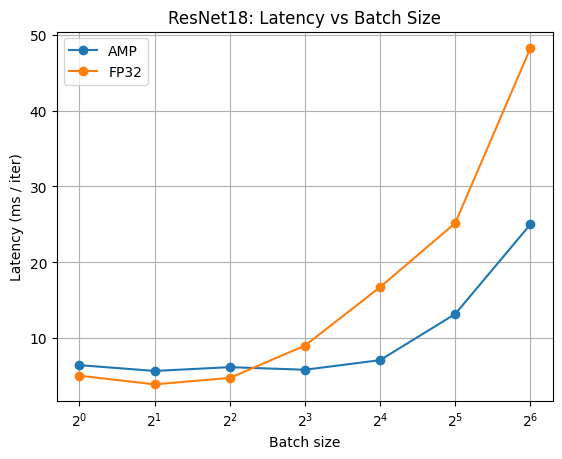

In [9]:
import matplotlib.pyplot as plt

plt.figure()
for prec, g in df_res.groupby("precision"):
    g = g.sort_values("batch")
    plt.plot(g["batch"], g["ms"], marker="o", label=prec)

plt.xscale("log", base=2)
plt.xlabel("Batch size")
plt.ylabel("Latency (ms / iter)")
plt.title("ResNet18: Latency vs Batch Size")
plt.grid(True, which="both")
plt.legend()
plt.show()


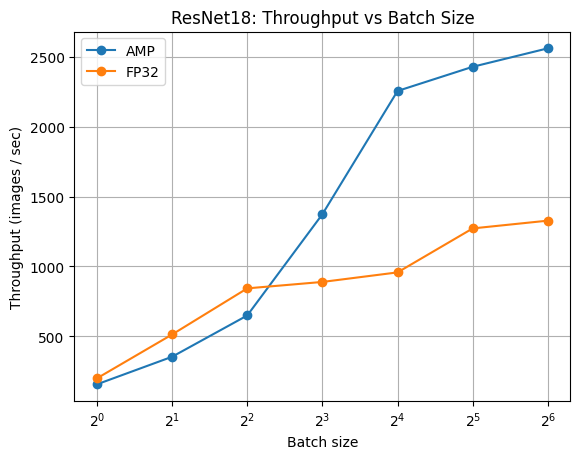

In [10]:
plt.figure()
for prec, g in df_res.groupby("precision"):
    g = g.sort_values("batch")
    plt.plot(g["batch"], g["throughput"], marker="o", label=prec)

plt.xscale("log", base=2)
plt.xlabel("Batch size")
plt.ylabel("Throughput (images / sec)")
plt.title("ResNet18: Throughput vs Batch Size")
plt.grid(True, which="both")
plt.legend()
plt.show()


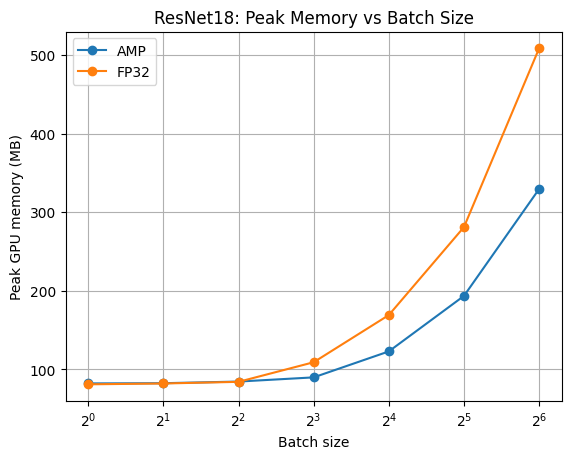

In [11]:
plt.figure()
for prec, g in df_res.groupby("precision"):
    g = g.sort_values("batch")
    plt.plot(g["batch"], g["mem_mb"], marker="o", label=prec)

plt.xscale("log", base=2)
plt.xlabel("Batch size")
plt.ylabel("Peak GPU memory (MB)")
plt.title("ResNet18: Peak Memory vs Batch Size")
plt.grid(True, which="both")
plt.legend()
plt.show()


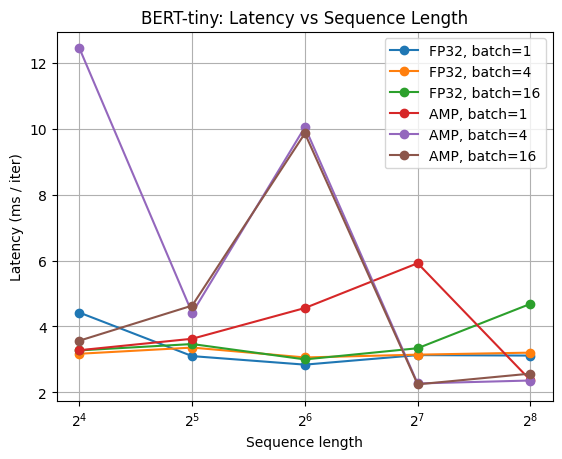

In [12]:
batches_to_plot = [1, 4, 16]  # change if you want

plt.figure()
for prec in ["FP32", "AMP"]:
    for b in batches_to_plot:
        g = df_bert[(df_bert["precision"] == prec) & (df_bert["batch"] == b)].sort_values("seq_len")
        if len(g) == 0:
            continue
        plt.plot(g["seq_len"], g["ms"], marker="o", label=f"{prec}, batch={b}")

plt.xscale("log", base=2)
plt.xlabel("Sequence length")
plt.ylabel("Latency (ms / iter)")
plt.title("BERT-tiny: Latency vs Sequence Length")
plt.grid(True, which="both")
plt.legend()
plt.show()


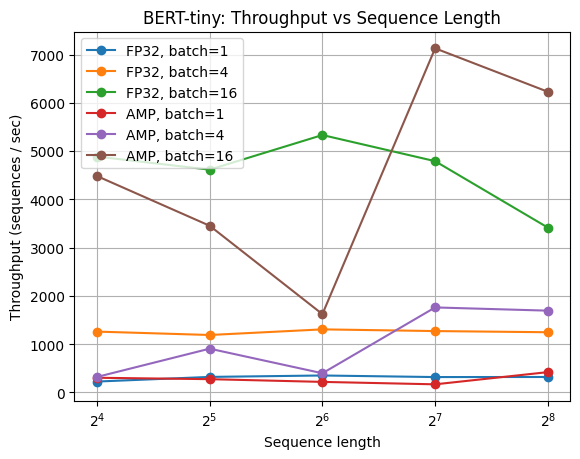

In [13]:
plt.figure()
for prec in ["FP32", "AMP"]:
    for b in batches_to_plot:
        g = df_bert[(df_bert["precision"] == prec) & (df_bert["batch"] == b)].sort_values("seq_len")
        if len(g) == 0:
            continue
        plt.plot(g["seq_len"], g["throughput"], marker="o", label=f"{prec}, batch={b}")

plt.xscale("log", base=2)
plt.xlabel("Sequence length")
plt.ylabel("Throughput (sequences / sec)")
plt.title("BERT-tiny: Throughput vs Sequence Length")
plt.grid(True, which="both")
plt.legend()
plt.show()


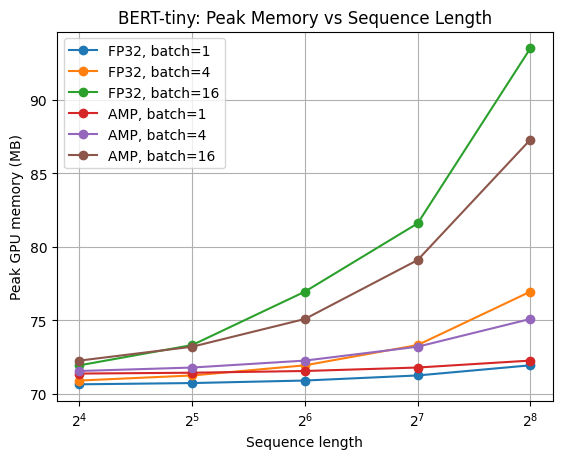

In [14]:
plt.figure()
for prec in ["FP32", "AMP"]:
    for b in batches_to_plot:
        g = df_bert[(df_bert["precision"] == prec) & (df_bert["batch"] == b)].sort_values("seq_len")
        if len(g) == 0:
            continue
        plt.plot(g["seq_len"], g["mem_mb"], marker="o", label=f"{prec}, batch={b}")

plt.xscale("log", base=2)
plt.xlabel("Sequence length")
plt.ylabel("Peak GPU memory (MB)")
plt.title("BERT-tiny: Peak Memory vs Sequence Length")
plt.grid(True, which="both")
plt.legend()
plt.show()


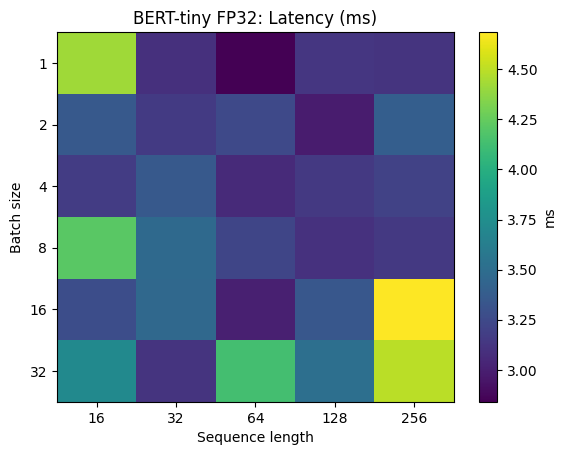

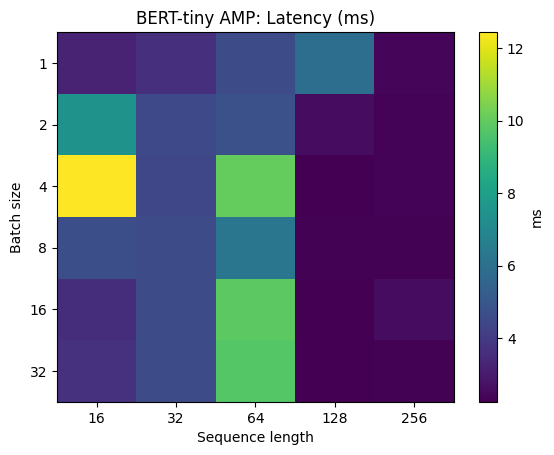

In [15]:
import numpy as np

def heatmap(df, precision="FP32", value_col="ms", title=""):
    sub = df[df["precision"] == precision].copy()
    pivot = sub.pivot_table(index="batch", columns="seq_len", values=value_col, aggfunc="mean").sort_index()
    plt.figure()
    plt.imshow(pivot.values, aspect="auto")
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xlabel("Sequence length")
    plt.ylabel("Batch size")
    plt.title(title)
    plt.colorbar(label=value_col)
    plt.show()

heatmap(df_bert, precision="FP32", value_col="ms", title="BERT-tiny FP32: Latency (ms)")
heatmap(df_bert, precision="AMP",  value_col="ms", title="BERT-tiny AMP: Latency (ms)")
